# Mortgage dashboard with cuxfilter and dask_cudf

## Import dask_cuda, dask

In [ ]:
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster

client = Client(LocalCUDACluster())

### Display total available GPU resources

In [3]:
gpu_info = client.cluster.scheduler_info['workers'].values()

print(f"Total GPUs: {len(gpu_info)}\n")
for gpu in gpu_info:
    mem = f"{gpu['memory_limit']/(1024 **3):.2f} GB"
    gpu_mem = f"{gpu['gpu']['memory-total']/(1024 **3):.2f} GB"
    gpu_name = gpu['gpu']['name']
    print(f"{gpu_name}:\n\tMemory assigned: {mem}, Total Memory: {gpu_mem}")

Total GPUs: 2

NVIDIA TITAN RTX:
	Memory assigned: 15.63 GB, Total Memory: 24.00 GB
Quadro GV100:
	Memory assigned: 15.63 GB, Total Memory: 32.00 GB


## Import cuxfilter

In [ ]:
import cuxfilter
import dask_cudf

from bokeh import palettes
from cuxfilter.layouts import *
from bokeh.tile_providers import get_provider as gp
tile_provider = gp('STAMEN_TONER')

In [ ]:
#update data_dir if you have downloaded datasets elsewhere
DATA_DIR = '../data'

## Download required datasets

In [ ]:
! curl https://data.rapids.ai/viz-data/146M_predictions_v2.arrow.gz --create-dirs -o $DATA_DIR/146M_predictions_v2.arrow.gz

In [ ]:
from cuxfilter.sampledata import datasets_check
datasets_check('mortgage', base_dir=DATA_DIR)

## Load required datasets using dask_cudf

Using `dask_cudf.DataFrame.persist()` before passing it to cuxfilter.DataFrame turns a lazy Dask collection into a Dask collection with the same metadata, but now with the results fully computed or actively computing in the background. 

Passing a `dask_cudf.DataFrame` without `persist()` is also supported.

In [ ]:
from cuxfilter.dataframe import read_arrow
import cudf

cudf_df = cudf.DataFrame.from_arrow(read_arrow(DATA_DIR + '/146M_predictions_v2.arrow'))
cudf_ddf = dask_cudf.from_cudf(cudf_df, npartitions=2).persist()

In [27]:
cudf_ddf

<dask_cudf.DataFrame | 2 tasks | 2 npartitions>

## Define charts

In [ ]:
cux_df = cuxfilter.DataFrame.from_dataframe(cudf_ddf)

In [ ]:
geoJSONSource='https://raw.githubusercontent.com/rapidsai/cuxfilter/GTC-2018-mortgage-visualization/javascript/demos/GTC%20demo/src/data/zip3-ms-rhs-lessprops.json'

In [ ]:
chart0 = cuxfilter.charts.choropleth(
    x='zip',
    color_column='delinquency_12_prediction', color_aggregate_fn='mean',
    elevation_column='current_actual_upb', elevation_factor=0.00001, elevation_aggregate_fn='sum', 
    geoJSONSource=geoJSONSource,
    data_points=1000, tooltip=True
)

In [ ]:
chart2 = cuxfilter.charts.bar('delinquency_12_prediction',data_points=50)
chart3 = cuxfilter.charts.range_slider('borrower_credit_score',data_points=50)

### Add mappings for chart1

In [ ]:
mapper1 = {}

for val in cux_df.data.dti.unique().compute().to_pandas().tolist():
    mapper1[int(val)] = 'l_'+str(val)

chart1 = cuxfilter.charts.panel_widgets.drop_down('dti', label_map=mapper1)
#also available: panel_widgets.multi_select

## Create a dashboard object

In [ ]:
d = cux_df.dashboard([chart0, chart2], sidebar=[chart1], layout=cuxfilter.layouts.feature_and_base, theme=cuxfilter.themes.dark, title="Mortgage Dashboard")
d.add_charts(sidebar=[chart3])

In [ ]:
#View Individual charts - uncomment below line
# chart0.view()

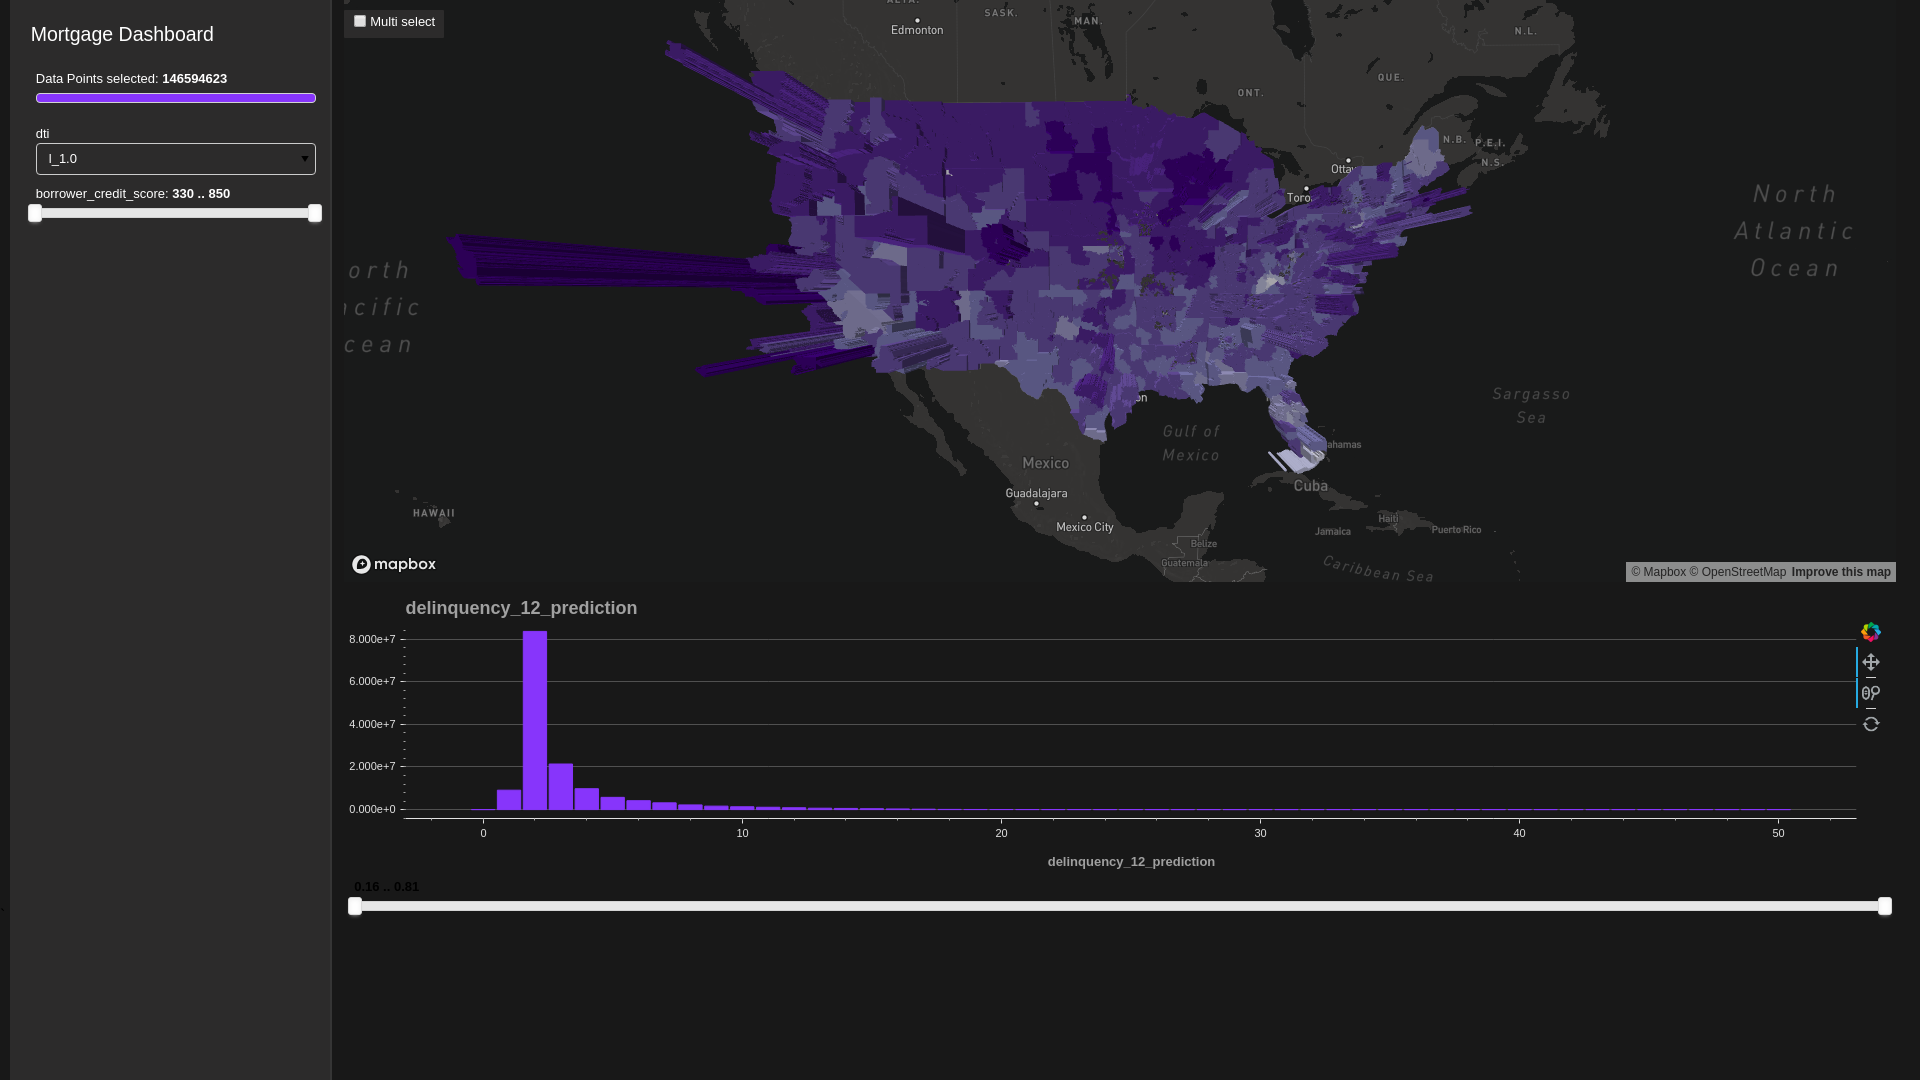

In [15]:
#execute below line for dashboard preview
# await d.preview()

## Starting the dashboard

1. d.show('current_notebook_url:current_notebook_port') remote dashboard

2. d.app() inline within the notebook cell

Incase you need to stop the server:

- d.stop()

In [ ]:
# d.show() # notebook_url="http://localhost:8888"
# d.app() # run the dashboard within the notebook cell

## Export the queried data into a dataframe

In [ ]:
queried_df = d.export()